# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# на гпу только эта версия работает
!pip install implicit==0.4.0

     |████████████████████████████████| 1.1MB 3.5MB/s 
  Created wheel for implicit: filename=implicit-0.4.0-cp36-cp36m-linux_x86_64.whl size=3390317 sha256=294d36edd768cf296ce9e64c9802d284797823cd1bb1ca168d3cf8437267c49c
  Stored in directory: /root/.cache/pip/wheels/fd/d1/66/84e83191d9f626c521271023e4ef83e634e3b8c154f2c4b2da
Successfully built implicit


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/'My Drive'/retail_train.csv /content
!cp /content/drive/'My Drive'/product.csv /content
!cp /content/drive/'My Drive'/hh_demographic.csv /content
!cp -r /content/drive/'My Drive'/src /content

### Класс MainRecommender

In [4]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """Рекоммендации, которые можно получить из ALS
    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, weighting=True):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

        self.als_user_factors = self.model.user_factors
        self.als_item_factors = self.model.item_factors

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          values='quantity',  # Можно пробовать другие варианты
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=8)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=32, regularization=0.001, iterations=15, num_threads=8):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        #self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                        user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        recalculate_user=True)]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        # Обработка холодного пользователя
        if user not in self.userid_to_id.keys():
          #self._update_dict(user_id=user)
          return self.overall_top_purchases[:N]
        else:
        #self._update_dict(user_id=user)
          return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        if user not in self.userid_to_id.keys():
          return self.overall_top_purchases[:N]
        else:
          return self._get_recommendations(user, model=self.own_recommender, N=N)
        #self._update_dict(user_id=user)
        

    def get_similar_items_recommendation(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        if user not in self.userid_to_id.keys():
          return self.overall_top_purchases[:N]
        else:
          top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

          res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
          res = self._extend_with_top_popular(res, N=N)

          assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
          return res

    def get_similar_users_recommendation(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
        if user not in self.userid_to_id.keys():
          return self.overall_top_purchases[:N]
        else:
          res = []

          # Находим топ-N похожих пользователей
          similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
          similar_users = [rec[0] for rec in similar_users]
          similar_users = similar_users[1:]   # удалим юзера из запроса

          for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))

          res = self._extend_with_top_popular(res, N=N)

          assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
          return res

### Подготовка данных

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
import lightgbm

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
#from src.recommenders import MainRecommender

In [6]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [13]:
recommender = MainRecommender(data_train_lvl_1)

In [ ]:
recommender.get_als_recommendations(2375, N=200)

In [ ]:
recommender.get_own_recommendations(2375, N=200)

In [ ]:
recommender.get_similar_items_recommendation(2375, N=200)

In [ ]:
recommender.get_similar_users_recommendation(2375, N=200)

### Задание 1


#### A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall? 

In [14]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [15]:
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))

In [16]:
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [17]:
result_lvl_1['sim_item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=200))

In [19]:
result_lvl_1['sim_user_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=200))

In [31]:
result_lvl_1

,user_id,actual,als_rec,own_rec,sim_item_rec,sim_user_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1028238, 883616, 1037332, 1097909, 856942, 55...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1132789, 826597, 9297615, 5577022, 9803545, 9...","[932949, 957080, 6904419, 1079528, 929410, 977..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[9419528, 9553382, 12262832, 5569230, 949965, ...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[5567582, 7024847, 1053022, 6904613, 848684, 9..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[891423, 6391541, 846550, 1006878, 846502, 744...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[906830, 846550, 1111786, 999714, 6514160, 847...","[10198378, 886996, 937736, 857130, 998741, 108..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[965267, 919681, 1084036, 1082185, 1026118, 89...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 8357613, 941361, 999999, 110...","[963542, 894360, 1021935, 6391080, 5707857, 63..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[912817, 1039627, 10285022, 915715, 962777, 83...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1019247, 1044078, 7147145, 995478, 12352249, ...","[6552438, 901976, 852235, 839656, 1138292, 949..."
...,...,...,...,...,...,...
2149,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[844179, 916122, 899624, 12810393, 8065410, 10...","[872826, 983665, 991546, 1134296, 7441210, 974...","[985999, 5569845, 1041796, 998239, 1044078, 10...","[825317, 9527417, 942166, 8090508, 10457044, 9..."
2150,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[963971, 957951, 1050741, 899624, 12810391, 80...","[870515, 1117219, 1102207, 1057168, 1135834, 1...","[991223, 865026, 8177622, 8090521, 910473, 826...","[923670, 1057749, 9392700, 1024065, 899115, 11..."
2151,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[925766, 8119004, 12326050, 1115175, 995965, 8...","[1022066, 1076580, 1100379, 5565356, 931579, 8...","[1070820, 901062, 961620, 1056620, 1061982, 82...","[822115, 1015280, 1117219, 1001827, 897270, 10..."
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[5568378, 1029743, 907631, 5569230, 5569327, 9...","[7168055, 1128395, 6904613, 5570048, 889989, 8...","[901062, 5568995, 907631, 12132648, 1004906, 1...","[7147142, 864893, 988277, 9652066, 916990, 113..."


In [33]:
result_lvl_1.apply(lambda row: recall_at_k(row['als_rec'], row['actual'], k=200), axis=1).mean()

0.10193565701665158

In [34]:
result_lvl_1.apply(lambda row: recall_at_k(row['own_rec'], row['actual'], k=200), axis=1).mean()

0.1352815146098268

In [35]:
result_lvl_1.apply(lambda row: recall_at_k(row['sim_item_rec'], row['actual'], k=200), axis=1).mean()

0.09037717119996756

In [36]:
result_lvl_1.apply(lambda row: recall_at_k(row['sim_user_rec'], row['actual'], k=200), axis=1).mean()

0.008818793739142277

Own recommendtions + top-popular дают лучший recall

#### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [59]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [60]:
result_lvl_1['own_rec_500'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))
result_lvl_1['als_rec_500'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=500))

In [64]:
als_500 = result_lvl_1.apply(lambda row: recall_at_k(row['als_rec_500'], row['actual'], k=500), axis=1).mean()
als_200 = result_lvl_1.apply(lambda row: recall_at_k(row['als_rec_500'], row['actual'], k=200), axis=1).mean()
als_100 = result_lvl_1.apply(lambda row: recall_at_k(row['als_rec_500'], row['actual'], k=100), axis=1).mean()
als_50 = result_lvl_1.apply(lambda row: recall_at_k(row['als_rec_500'], row['actual'], k=50), axis=1).mean()
als_20 = result_lvl_1.apply(lambda row: recall_at_k(row['als_rec_500'], row['actual'], k=20), axis=1).mean()

own_500 = result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_500'], row['actual'], k=500), axis=1).mean()
own_200 = result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_500'], row['actual'], k=200), axis=1).mean()
own_100 = result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_500'], row['actual'], k=100), axis=1).mean()
own_50 = result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_500'], row['actual'], k=50), axis=1).mean()
own_20 = result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_500'], row['actual'], k=20), axis=1).mean()

In [66]:
als_recall = [als_20, als_50, als_100, als_200, als_500]
own_recall = [own_20, own_50, own_100, own_200, own_500]
k = [20, 50, 100, 200, 500]

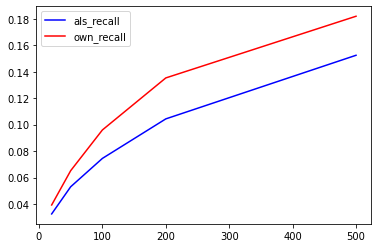

In [68]:
fig, ax = plt.subplots()
ax.plot(k, als_recall, '-b', label='als_recall')
ax.plot(k, own_recall, '-r', label='own_recall')
leg = ax.legend();

#### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Наиболее разумным является значение k = 200, так как при дальнейшем увеличении k recall изменяется незначительно

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

#### 2.1 Обучение одноуровневой модели

In [8]:
# Одноуровневую модель обучим на data_train_lvl_1+data_train_lvl_2 и протестируем на data_val_lvl_2
data_train_lvl_1and2 = pd.concat([data_train_lvl_1, data_train_lvl_2])

In [9]:
single_layer_model = MainRecommender(data_train_lvl_1and2)

In [10]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [11]:
result_lvl_2['single_layer_als'] = result_lvl_2['user_id'].apply(lambda x: single_layer_model.get_als_recommendations(x, N=5))

Двухуровневую модель будем в дальнейшем сравнивать с этим результатом

In [12]:
result_lvl_2.head()

,user_id,actual,single_layer_als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 9527558, 5577022, 877391]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 844179, 5569230, 1106523, 1029743]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1026118, 13002975, 848071, 1051516]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[7147142, 5981267, 959482, 5592610, 13987153]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1029743, 1082185, 916122, 1004906, 1068719]"


In [13]:
result_lvl_2.apply(lambda row: precision_at_k(row['single_layer_als'], row['actual'], k=5), axis=1).mean()

0.18374142997061485

#### 2.2 Первый уровень двухуровневой модели

На первом этапе отбираем 200 наиболее релевантных товаров

##### 2.2.1 Строим модель первого уровня

In [14]:
first_layer_model = MainRecommender(data_train_lvl_1)

##### 2.2.2 Оценим полноту первого уровня

In [15]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1['candidates'] = result_lvl_1['user_id'].apply(lambda x: first_layer_model.get_als_recommendations(x, N=200))
result_lvl_1.head(2)

,user_id,actual,candidates
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[885290, 1082212, 903609, 828588, 856942, 5577..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 5569845, 9881593, 1021324, 5570048, ..."


In [16]:
result_lvl_1.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=200), axis=1).mean()

0.10339148175305574

#### 2.3 Второй уровень двухуровневой модели

##### 2.3.1 Формируем датасет для обучения модели второго уровня

In [17]:
# Модель второго уровня будет обучаться на пользователях из второго датасета (data_train_lvl_2)
# и товарах, отфильтрованных моделью первого уровня для каждого пользователя из второго датасета
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Надо применять модель, которая дает наибольший recall
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: first_layer_model.get_als_recommendations(x, N=200))
users_lvl_2.head(3)

##### 2.3.2 "Разворачиваем" датасет

In [18]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,5569471,1
0,2070,1029743,1
0,2070,935993,1
0,2070,970866,1


##### 2.3.3 Добавляем значения целевой переменной

In [19]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,5569471,0.0
1,2070,1029743,0.0


##### 2.3.4 Обзор и обработка признаков пользователей, товаров и взаимодействий

In [28]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [99]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65,A,42000,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,50,A,62000,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [20]:
user_features['age_desc'] = \
user_features['age_desc'].map({'65+':65,'45-54':50,'25-34':30,'35-44':40,'19-24':22,'55-64':60})

In [21]:
user_features['income_desc'] = \
user_features['income_desc'].map({'35-49K':42000,'50-74K':62000,'25-34K':30000,'75-99K':87000,\
                                  'Under 15K':15000,'100-124K':112000,'15-24K':20000,'125-149K':137000,\
                                  '150-174K':162000,'250K+':250000,'175-199K':187000,'200-249K':225000})

In [22]:
user_features['household_size_desc'] = \
user_features['household_size_desc'].map({'2':2,'3':3,'4':4,'1':1,'5+':6})

In [23]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


##### 2.3.5 FEATURE ENGINEERING

Величина среднего чека для каждого пользователя

In [25]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [26]:
mean_check = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()

In [27]:
mean_check.head(5)

,user_id,basket_id,sales_value
0,1,40666800522,133.84
1,1,40765687204,5.98
2,1,40800826610,27.94
3,1,40826640752,26.77
4,1,40968886759,81.23


In [28]:
mean_check = mean_check.groupby('user_id')['sales_value'].mean().reset_index()

In [29]:
mean_check.rename(columns = {'sales_value': 'mean_check'}, inplace=True)

In [30]:
mean_check

,user_id,mean_check
0,1,48.825714
1,2,47.572500
2,4,39.796667
3,6,20.562500
4,7,37.530000
...,...,...
2149,2496,69.372000
2150,2497,31.147222
2151,2498,14.180000
2152,2499,30.782500


Средняя стоимость каждого товара

In [31]:
tmp = data_train_lvl_2.copy()

In [32]:
tmp.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [33]:
tmp = tmp.merge(item_features, on='item_id', how='left')

In [34]:
mean_sales_value_for_item_id = tmp.groupby(['item_id'])['sales_value'].mean().reset_index()

In [35]:
mean_sales_value_for_item_id.rename(columns = {'sales_value': 'msv_item_id'}, inplace=True)

In [36]:
mean_sales_value_for_item_id.head(3)

,item_id,msv_item_id
0,28116,0.33
1,28117,0.34
2,28143,0.33


Средняя стоимость товаров из department, которые купил пользователь

In [37]:
mean_sales_value_for_department = tmp.groupby(['user_id','department'])['sales_value'].mean().reset_index()

In [38]:
mean_sales_value_for_department.rename(columns = {'sales_value': 'msv_department'}, inplace=True)

In [39]:
mean_sales_value_for_department.head(3)

,user_id,department,msv_department
0,1,,0.000000
1,1,DELI,2.437500
2,1,DRUG GM,4.143846


Средняя стоимость товаров из commodity_desc, которые купил пользователь

In [40]:
mean_sales_value_for_com_des = tmp.groupby(['user_id','commodity_desc'])['sales_value'].mean().reset_index()

In [41]:
mean_sales_value_for_com_des.rename(columns = {'sales_value': 'msv_com_des'}, inplace=True)

In [42]:
mean_sales_value_for_com_des.head(3)

,user_id,commodity_desc,msv_com_des
0,1,,0.000000
1,1,AIR CARE,3.333333
2,1,APPLES,1.575000


Средняя стоимость товаров из sub_commodity_desc, которые купил пользователь

In [43]:
mean_sales_value_for_sub_com_des = tmp.groupby(['user_id','sub_commodity_desc'])['sales_value'].mean().reset_index()

In [44]:
mean_sales_value_for_sub_com_des.rename(columns = {'sales_value': 'msv_sub_com_des'}, inplace=True)

In [45]:
mean_sales_value_for_sub_com_des.head(3)

,user_id,sub_commodity_desc,msv_sub_com_des
0,1,,0.00
1,1,AEROSOL TOPPINGS,1.99
2,1,AIR CARE - CANDLES,2.50


Сколько раз данный пользователь купил данный товар за всю историю

In [46]:
item_quan_user = tmp.groupby(['user_id','item_id'])['quantity'].sum().reset_index()

In [47]:
item_quan_user.rename(columns = {'quantity': 'total_quantity'}, inplace=True)

In [48]:
item_quan_user.head(3)

,user_id,item_id,total_quantity
0,1,820165,4
1,1,829323,1
2,1,829563,1


Сколько денег данный пользователь потратил на данный товар за всю историю

In [49]:
item_sv_user = tmp.groupby(['user_id','item_id'])['sales_value'].sum().reset_index()

In [50]:
item_sv_user.rename(columns = {'sales_value': 'item_sv_user'}, inplace=True)

In [51]:
item_sv_user.head(3)

,user_id,item_id,item_sv_user
0,1,820165,2.00
1,1,829323,1.53
2,1,829563,1.88


Сколько денег данный пользователь потратил на товары из department за всю историю

In [52]:
total_money_depart = tmp.groupby(['user_id','department'])['sales_value'].sum().reset_index()
total_money_depart.rename(columns = {'sales_value': 'total_money_depart'}, inplace=True)
total_money_depart.head(3)

,user_id,department,total_money_depart
0,1,,0.00
1,1,DELI,9.75
2,1,DRUG GM,53.87


Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю

In [53]:
total_money_com_desc = tmp.groupby(['user_id','commodity_desc'])['sales_value'].sum().reset_index()
total_money_com_desc.rename(columns = {'sales_value': 'total_money_com_desc'}, inplace=True)
total_money_com_desc.head(3)

,user_id,commodity_desc,total_money_com_desc
0,1,,0.00
1,1,AIR CARE,10.00
2,1,APPLES,3.15


Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю

In [54]:
total_money_sub_com_desc = tmp.groupby(['user_id','sub_commodity_desc'])['sales_value'].sum().reset_index()
total_money_sub_com_desc.rename(columns = {'sales_value': 'total_money_sub_com_desc'}, inplace=True)
total_money_sub_com_desc.head(3)

,user_id,sub_commodity_desc,total_money_sub_com_desc
0,1,,0.00
1,1,AEROSOL TOPPINGS,1.99
2,1,AIR CARE - CANDLES,2.50


In [55]:
user_features['age_desc'].unique()

array([65, 50, 30, 40, 22, 60])

In [56]:
tmp.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ


##### 2.3.6 Добавляем новые признаки

In [57]:
# Добавляем признаки из item_features
targets_lvl_2 = targets_lvl_2.merge(item_features[['item_id','department',\
                                                   'commodity_desc','sub_commodity_desc']], \
                                                    on='item_id', how='left')
# Средний чек для каждого пользователя
targets_lvl_2 = targets_lvl_2.merge(mean_check, on='user_id', how='left')
# Средняя стоимость для каждого товара
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_for_item_id, on='item_id', how='left')
# Средняя стоимость товаров из department, которые купил пользователь
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_for_department, on=['user_id', 'department'], how='left')
# Средняя стоимость товаров из commodity_desc, которые купил пользователь
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_for_com_des, on=['user_id', 'commodity_desc'], how='left')
# Средняя стоимость товаров из sub_commodity_desc, которые купил пользователь
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_for_sub_com_des, on=['user_id', 'sub_commodity_desc'], how='left')
# Сколько раз данный пользователь купил данный товар за всю историю
targets_lvl_2 = targets_lvl_2.merge(item_quan_user, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю
targets_lvl_2 = targets_lvl_2.merge(item_sv_user, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на товары из department за всю историю
targets_lvl_2 = targets_lvl_2.merge(total_money_depart, on=['user_id', 'department'], how='left')
# Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю
targets_lvl_2 = targets_lvl_2.merge(total_money_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю
targets_lvl_2 = targets_lvl_2.merge(total_money_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')

# Добавляем признаки из user_features
targets_lvl_2 = targets_lvl_2.merge(user_features[['user_id','age_desc','income_desc','household_size_desc']], on=['user_id'], how='left')

#targets_lvl_2['total_quantity'] = targets_lvl_2['total_quantity'].fillna(0)
#targets_lvl_2['item_sv_user'] = targets_lvl_2['item_sv_user'].fillna(0)

Добавим Embedding от als

In [181]:
als_user_fearures = pd.DataFrame(first_layer_model.userid_to_id.keys())
als_user_factors = pd.DataFrame(first_layer_model.als_user_factors)
als_user_fearures = pd.concat([als_user_fearures, als_user_factors], axis=1)
columns_names = ['user_id']
feature_nums = ['user_f_'+str(i) for i in range(als_user_fearures.shape[1] -1)]
columns_names = columns_names + feature_nums
als_user_fearures.columns = columns_names

In [186]:
als_item_fearures = pd.DataFrame(first_layer_model.itemid_to_id.keys())
als_item_factors = pd.DataFrame(first_layer_model.als_item_factors)
als_item_fearures = pd.concat([als_item_fearures, als_item_factors], axis=1)
columns_names = ['item_id']
feature_nums = ['item_f_'+str(i) for i in range(als_item_fearures.shape[1] -1)]
columns_names = columns_names + feature_nums
als_item_fearures.columns = columns_names

In [188]:
targets_lvl_2 = targets_lvl_2.merge(als_user_fearures, on=['user_id'], how='left')
targets_lvl_2 = targets_lvl_2.merge(als_item_fearures, on=['item_id'], how='left')

##### 2.3.7 Обучение модели второго уровня на тренировочном датасете

In [190]:
X_train = targets_lvl_2.drop(['target','department', 'commodity_desc', 'sub_commodity_desc'], axis=1)
y_train = targets_lvl_2[['target']]

In [60]:
#cat_feats = X_train.columns[2:].tolist()
#X_train[cat_feats] = X_train[cat_feats].astype('category')

#cat_feats

In [191]:
lgb = LGBMClassifier(objective='binary', max_depth=5)#, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [62]:
train_preds = lgb.predict(X_train)

##### 2.3.8 Формируем тестовый датасет

In [60]:
# Модель второго уровня будет валидироваться на пользователях из третьего датасета (data_val_lvl_2)
# и товарах, отфильтрованных моделью первого уровня для каждого пользователя из третьего датасета

test_dataset = pd.DataFrame(data_val_lvl_2['user_id'].unique())
test_dataset.columns = ['user_id']

# Применяем модель первого уровня
test_dataset['candidates'] = test_dataset['user_id'].apply(lambda x: first_layer_model.get_als_recommendations(x, N=200))
test_dataset.head(2)

In [62]:
# Разварачиваем датасет

s = test_dataset.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

test_dataset = test_dataset.drop('candidates', axis=1).join(s)
#test_dataset['drop'] = 1  # фиктивная переменная

test_dataset.head(4)

,user_id,item_id
0,338,13002975
0,338,835300
0,338,896613
0,338,871611


In [63]:
# Добавляем признаки из item_features
test_dataset = test_dataset.merge(item_features[['item_id','department',\
                                                   'commodity_desc','sub_commodity_desc']],\
                                                    on='item_id', how='left')
# Средний чек
test_dataset = test_dataset.merge(mean_check, on='user_id', how='left')
# Средняя стоимость для каждого товара
test_dataset = test_dataset.merge(mean_sales_value_for_item_id, on='item_id', how='left')
# Средняя стоимость товаров в department для пользователя
test_dataset = test_dataset.merge(mean_sales_value_for_department, on=['user_id', 'department'], how='left')
# Средняя стоимость товаров в commodity_desc для пользователя
test_dataset = test_dataset.merge(mean_sales_value_for_com_des, on=['user_id', 'commodity_desc'], how='left')
# Средняя стоимость товаров в sub_commodity_desc для пользователя
test_dataset = test_dataset.merge(mean_sales_value_for_sub_com_des, on=['user_id', 'sub_commodity_desc'], how='left')
# Сколько раз данный пользователь купил данный товар за всю историю
test_dataset = test_dataset.merge(item_quan_user, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю
test_dataset = test_dataset.merge(item_sv_user, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на товары из department за всю историю
test_dataset = test_dataset.merge(total_money_depart, on=['user_id', 'department'], how='left')
# Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю
test_dataset = test_dataset.merge(total_money_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю
test_dataset = test_dataset.merge(total_money_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')

# Добавляем признаки из user_features
test_dataset = test_dataset.merge(user_features[['user_id','age_desc','income_desc','household_size_desc']], on=['user_id'], how='left')

#test_dataset['total_quantity'] = test_dataset['total_quantity'].fillna(0)
#test_dataset['item_sv_user'] = test_dataset['item_sv_user'].fillna(0)

In [192]:
test_dataset = test_dataset.merge(als_user_fearures, on=['user_id'], how='left')
test_dataset = test_dataset.merge(als_item_fearures, on=['item_id'], how='left')

##### 2.3.9 Получаем предсказания и обрабатываем результат

In [193]:
test_preds = lgb.predict(test_dataset.drop(['department', 'commodity_desc', 'sub_commodity_desc'], axis=1))
#test_preds = lgb.predict_proba(test_dataset.drop(['department', 'commodity_desc', 'sub_commodity_desc'], axis=1))[:, 1]
result = test_dataset[['user_id',	'item_id']]

result['prob'] = test_preds
result.sort_values(by = ['user_id', 'prob'], ascending=False, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [195]:
result.head(5)

,user_id,item_id,prob
30662,2500,1065538,1.0
30679,2500,854405,1.0
30600,2500,1133745,0.0
30601,2500,1086061,0.0
30602,2500,1003649,0.0


In [196]:
# Группируем товары для каждого пользователя
result = result.groupby('user_id')['item_id'].unique().reset_index()

# Оставляем ТОП-5 товаров для каждого пользователя
result['item_id'] = result['item_id'].apply(lambda x: x[:5])


# Вычисли длины всех предложений
result['row_len'] = result['item_id'].apply(lambda x: len(x))

print('Кол-во рекомендаций с длиной != 5 ', result[result['row_len'] != 5].shape[0])

Кол-во рекомендаций с длиной != 5  0


In [197]:
result.head(2)

,user_id,item_id,row_len
0,1,"[1082212, 856942, 5577022, 9655212, 9526676]",5
1,3,"[1044078, 1020581, 1075979, 12301100, 1106523]",5


In [198]:
als_plus_lgbm = result.drop(columns = ['row_len'])

In [199]:
als_plus_lgbm.head(2)

,user_id,item_id
0,1,"[1082212, 856942, 5577022, 9655212, 9526676]"
1,3,"[1044078, 1020581, 1075979, 12301100, 1106523]"


##### 2.3.10 Добавляем полученный результат в итоговую таблицу для оценки метрик

In [200]:
result_all = result_lvl_2.merge(als_plus_lgbm, how='left', on='user_id')
result_all.rename(columns = {'item_id': 'als_plus_lgbm'}, inplace=True)
result_all.head(3)

,user_id,actual,single_layer_als,als_plus_lgbm
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 9527558, 5577022, 877391]","[1082212, 856942, 5577022, 9655212, 9526676]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 844179, 5569230, 1106523, 1029743]","[1044078, 1020581, 1075979, 12301100, 1106523]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1026118, 13002975, 848071, 1051516]","[878996, 1082185, 6548453, 1024306, 900802]"


In [201]:
result_all.apply(lambda row: precision_at_k(row['single_layer_als'], row['actual'], k=5), axis=1).mean()

0.18374142997061485

In [202]:
result_all.apply(lambda row: precision_at_k(row['als_plus_lgbm'], row['actual'], k=5), axis=1).mean()

0.2176297747306542

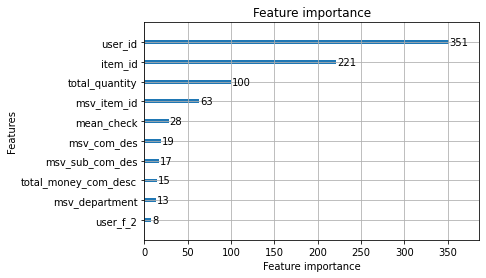

In [203]:
lightgbm.plot_importance(lgb, max_num_features=10)

In [206]:
0.2176 - 0.1837

0.033899999999999986

Использование двухуровневой модели повысило precision@5 на 0.034

-----------------------------------------------------

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)

In [77]:
all_result = result_lvl_2.copy()

In [78]:
all_result.head(3)

,user_id,actual,single_layer_als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 5577022, 9297615, 1135983, 9527558]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 844179, 5569230, 1106523, 1029743]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1026118, 13002975, 970160, 848071]"


In [215]:
data_train_lvl_2.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0


In [216]:
targets_lvl_2.head(3)

,user_id,item_id,target,department,commodity_desc,sub_commodity_desc,mean_check,msv_item_id,msv_department,msv_com_des,msv_sub_com_des,total_quantity,item_sv_user,total_money_depart,total_money_com_desc,total_money_sub_com_desc
0,2070,865456,1.0,GROCERY,CHEESE,LOAF CHEESE,14.355581,4.491463,2.23964,3.942500,3.990,1.0,3.99,311.31,31.54,3.99
1,2070,5569374,0.0,GROCERY,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,14.355581,4.734000,2.23964,1.251875,NaN,NaN,NaN,311.31,40.06,NaN
2,2070,12810391,1.0,MEAT,PORK,ENHANCED,14.355581,23.998000,13.31625,14.095000,14.095,1.0,17.59,106.53,28.19,28.19


In [217]:
test_dataset.head(3)

,user_id,item_id,department,commodity_desc,sub_commodity_desc,mean_check,msv_item_id,msv_department,msv_com_des,msv_sub_com_des,total_quantity,item_sv_user,total_money_depart,total_money_com_desc,total_money_sub_com_desc
0,338,1084036,MEAT,CHICKEN,INTERNAL,15.4925,1.944545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,13002975,MEAT,BEEF,RIBS,15.4925,5.963333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,338,934639,MEAT,CHICKEN,CHICKEN DRUMS,15.4925,2.618788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
all_result = result_lvl_2.copy()

X_train = targets_lvl_2.drop(['target', 'department', 'commodity_desc', 'sub_commodity_desc'], axis=1)
y_train = targets_lvl_2[['target']]

lgb = LGBMClassifier(objective='binary', max_depth=10, n_estimators=100)#, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

result = test_dataset[['user_id',	'item_id']]
test_preds = lgb.predict(test_dataset.drop(['department', 'commodity_desc', 'sub_commodity_desc'], axis=1))
result['prob'] = test_preds

result.sort_values(by = ['user_id', 'prob'], ascending=False, inplace=True)
# Группируем товары для каждого пользователя
result = result.groupby('user_id')['item_id'].unique().reset_index()
# Оставляем ТОП-5 товаров для каждого пользователя
result['item_id'] = result['item_id'].apply(lambda x: x[:5])
# Вычисли длины всех предложений
result['row_len'] = result['item_id'].apply(lambda x: len(x))
print('Кол-во рекомендаций с длиной != 5 ', result[result['row_len'] != 5].shape[0])
als_plus_lgbm = result.drop(columns = ['row_len'])

all_result = all_result.merge(als_plus_lgbm, how='left', on='user_id')
all_result.apply(lambda row: precision_at_k(row['single_layer_als'], row['actual'], k=5), axis=1).mean()
all_result.apply(lambda row: precision_at_k(row['item_id'], row['actual'], k=5), axis=1).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.p

Кол-во рекомендаций с длиной != 5  0


0.2176297747306542

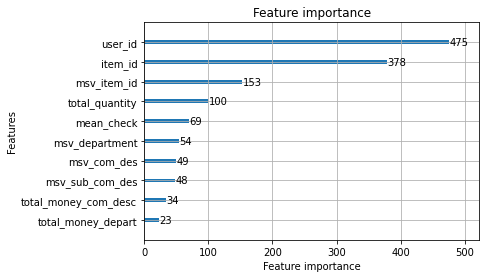

In [205]:
lightgbm.plot_importance(lgb, max_num_features=10)

In [242]:
all_result

,user_id,actual,single_layer_als,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9655212, 877391, 9527558, 869465]","[9527558, 856942, 5577022, 9297615, 9655212]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 844179, 5569230, 1106523, 1029743]","[1044078, 998206, 1075979, 844179, 1016800]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1051516, 1026118, 6979393, 1082185, 1015296]","[1082185, 878996, 1098844, 6548453, 845208]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1137507, 5981267, 5590695, 844685, 7147142]","[1122358, 5592610, 9338009, 925579, 915715]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[916122, 1029743, 1066069, 1105623, 1081853]","[837304, 1013389, 1029743, 12301839, 878285]"
...,...,...,...,...
2037,2496,[6534178],"[899624, 5569230, 844179, 16122432, 1000753]","[899624, 916122, 12810393, 999858, 865456]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[899624, 844179, 1044078, 963971, 1102207]","[1051323, 870515, 1029743, 1102207, 1081177]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[987734, 916122, 7157438, 831246, 9487286]","[844991, 940766, 1100379, 951197, 9487534]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[1106523, 5569230, 1044078, 1029743, 866211]","[5568378, 954651, 5569327, 5572738, 1060872]"
